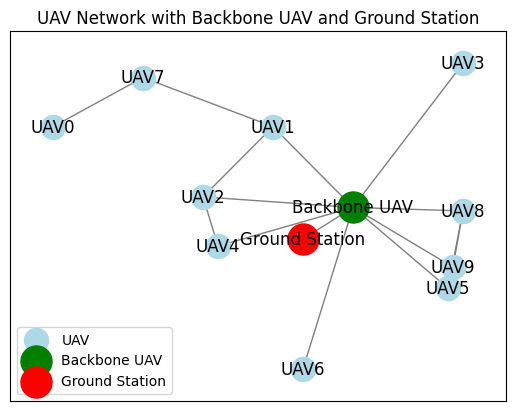

In [2]:
import networkx as nx
import matplotlib.pyplot as plt
import random
import numpy as np
import time
from neo4j import GraphDatabase

# Neo4j configuration
URI = "neo4j://localhost:7687"
AUTH = ("neo4j", "Shady5000$")

class UAVNetworkSimulation:

    def __init__(self, uri, auth):
        self.driver = GraphDatabase.driver(uri, auth=auth)

    def close(self):
        self.driver.close()

    def create_initial_graph(self, num_uavs, connection_range, ground_station_pos, backbone_range):
        G = nx.Graph()

        # Add UAV nodes
        # for i in range(num_uavs):
        #     G.add_node(i, pos=(random.randint(0, 100), random.randint(0, 100)))
        # Define typical throughput and latency ranges (for example purposes)
        typical_throughput = (50, 100)  # Mbps
        typical_latency = (10, 50)     # Milliseconds

        # Add UAV nodes with properties
        for i in range(num_uavs):
            throughput = random.randint(*typical_throughput)
            latency = random.randint(*typical_latency)
            G.add_node(i, pos=(random.randint(0, 100), random.randint(0, 100)),
                       throughput=throughput, latency=latency)

        # Add Backbone UAV
        backbone_uav_id = num_uavs
        G.add_node(backbone_uav_id, pos=(random.randint(0, 100), random.randint(0, 100)), is_backbone=True,
                       throughput=throughput, latency=latency)

        # Connect Backbone UAV to other UAVs
        for i in range(num_uavs):
            pos_i = G.nodes[i]['pos']
            pos_backbone = G.nodes[backbone_uav_id]['pos']
            distance = np.linalg.norm(np.array(pos_i) - np.array(pos_backbone))
            if distance <= backbone_range:
                G.add_edge(i, backbone_uav_id, weight=distance)

        # Add and connect the Ground Station
        ground_station_id = num_uavs + 1
        G.add_node(ground_station_id, pos=ground_station_pos, is_ground_station=True)
        G.add_edge(backbone_uav_id, ground_station_id)

        # Add edges between UAVs within connection range
        for i in range(num_uavs):
            for j in range(i + 1, num_uavs):
                pos_i = G.nodes[i]['pos']
                pos_j = G.nodes[j]['pos']
                distance = np.linalg.norm(np.array(pos_i) - np.array(pos_j))
                if distance <= connection_range:
                    G.add_edge(i, j, weight=distance)

        return G

    def upload_to_neo4j(self, G):
        with self.driver.session() as session:
            # Clear existing data
            session.run("MATCH (n) DETACH DELETE n")

            # Add nodes
            for node in G.nodes:
                is_backbone = G.nodes[node].get('is_backbone', False)
                is_ground_station = G.nodes[node].get('is_ground_station', False)

                if is_backbone:
                    session.run(f"""
                        CREATE (b:BackboneUAV {{id: $id, pos: $pos, uavType: $uavType,
                            throughput: $throughput, latency: $latency}})
                        """, id=node, pos=G.nodes[node]['pos'], uavType = "Backbone UAV", throughput=G.nodes[node]['throughput'],
                        latency=G.nodes[node]['latency'])
                elif is_ground_station:
                    session.run(f"""
                        CREATE (g:GroundStation {{id: $id, pos: $pos, gsName: $GS}})
                        """, id=node, pos=G.nodes[node]['pos'], GS = "Ground Station")
                else:
                    session.run(f"""
                        CREATE (u:UAV {{id: $id, pos: $pos, uavType: $uavType, uavName: $uavName,
                            throughput: $throughput + 'mb/s', latency: $latency + 'ms'}})
                        """, id=node, pos=G.nodes[node]['pos'], uavType = "UAV", uavName = "UAV"  + str(node), throughput=G.nodes[node]['throughput'],
                        latency=G.nodes[node]['latency'])

            # Add relationships
            for source, target in G.edges:
                session.run("""
                    MATCH (a), (b)
                    WHERE a.id = $source AND b.id = $target
                    CREATE (a)-[:COMMUNICATES_WITH]->(b)
                    """, source=source, target=target)


    def draw_graph(self, G):
        pos = nx.get_node_attributes(G, 'pos')

        # Prepare custom labels
        labels = {}
        for node in G.nodes:
            if G.nodes[node].get('is_backbone', False):
                labels[node] = 'Backbone UAV'
            elif G.nodes[node].get('is_ground_station', False):
                labels[node] = 'Ground Station'
            else:
                labels[node] = f'UAV{node}'

        # Differentiate node types
        regular_nodes = [node for node in G.nodes if not G.nodes[node].get('is_backbone', False) and not G.nodes[node].get('is_ground_station', False)]
        backbone_nodes = [node for node in G.nodes if G.nodes[node].get('is_backbone', False)]
        ground_station_nodes = [node for node in G.nodes if G.nodes[node].get('is_ground_station', False)]

        # Draw regular UAV nodes
        nx.draw_networkx_nodes(G, pos, nodelist=regular_nodes, node_color='lightblue', node_size=300, label='UAV')
        
        # Draw backbone UAV node
        nx.draw_networkx_nodes(G, pos, nodelist=backbone_nodes, node_color='green', node_size=500, label='Backbone UAV')

        # Draw ground station node
        nx.draw_networkx_nodes(G, pos, nodelist=ground_station_nodes, node_color='red', node_size=500, label='Ground Station')

        # Draw edges
        nx.draw_networkx_edges(G, pos, edge_color='gray')

        # Draw custom labels
        nx.draw_networkx_labels(G, pos, labels)

        plt.title("UAV Network with Backbone UAV and Ground Station")
        plt.legend()
        plt.show()
        
    def update_uav_positions(self, G, move_range):
        """
        Update the positions of UAVs randomly within a given range.
        """
        for node in G.nodes:
            if 'is_backbone' not in G.nodes[node] and 'is_ground_station' not in G.nodes[node]:
                current_pos = G.nodes[node]['pos']
                new_pos = (current_pos[0] + random.uniform(-move_range, move_range), 
                           current_pos[1] + random.uniform(-move_range, move_range))
                G.nodes[node]['pos'] = new_pos
        return G

    def update_network_connections(self, G, connection_range, backbone_range):
        """
        Update the network connections based on new positions and connection range.
        """
        num_uavs = len(G.nodes) - 2  # Excluding backbone UAV and ground station
        backbone_uav_id = num_uavs

        # Update connections for regular UAVs
        for i in range(num_uavs):
            for j in range(i + 1, num_uavs):
                if G.has_edge(i, j):
                    G.remove_edge(i, j)
                pos_i = G.nodes[i]['pos']
                pos_j = G.nodes[j]['pos']
                distance = np.linalg.norm(np.array(pos_i) - np.array(pos_j))
                if distance <= connection_range:
                    G.add_edge(i, j, weight=distance)

        # Update connections for the Backbone UAV
        for i in range(num_uavs):
            if G.has_edge(i, backbone_uav_id):
                G.remove_edge(i, backbone_uav_id)
            pos_i = G.nodes[i]['pos']
            pos_backbone = G.nodes[backbone_uav_id]['pos']
            distance = np.linalg.norm(np.array(pos_i) - np.array(pos_backbone))
            if distance <= backbone_range:
                G.add_edge(i, backbone_uav_id, weight=distance)

        return G

    def update_neo4j_database(self, G):
        """
        Update the Neo4j database with the new positions and connections.
        """
        with self.driver.session() as session:
            # Update positions
            for node in G.nodes:
                pos = G.nodes[node]['pos']
                session.run("""
                    MATCH (n)
                    WHERE n.id = $id
                    SET n.pos = $pos
                    """, id=node, pos=pos)

            # Update relationships
            session.run("MATCH (n)-[r:COMMUNICATES_WITH]->() DELETE r")
            for source, target in G.edges:
                session.run("""
                    MATCH (a), (b)
                    WHERE a.id = $source AND b.id = $target
                    CREATE (a)-[:COMMUNICATES_WITH]->(b)
                    """, source=source, target=target)
                
    def run_simulation(self, G, total_time, update_interval, move_range, connection_range, backbone_range, num_packets):
        """
        Run the simulation for a specified period of time.
        """
        start_time = time.time()
        iteration = 0
        while time.time() - start_time < total_time:
            print(f"Iteration {iteration}:")
            iteration += 1
            # Update UAV positions
            self.update_uav_positions(G, move_range)

            # Update network connections
            self.update_network_connections(G, connection_range, backbone_range)

            # Optional: Update Neo4j database and redraw the graph at each step
            # self.update_neo4j_database(G)
            # self.draw_graph(G)
            packets = self.generate_network_traffic(G, num_packets)
            routed_packets = self.route_packets(G, packets)

             # Log the routed packets information
            for i, packet in enumerate(routed_packets):
                print(f"  Packet {i}: Source: {packet['source']}, Target: {packet['target']}, "
                      f"Size: {packet['size']}, Delivered: {packet['delivered']}, "
                      f"Path: {packet['path']}, Total Latency: {packet['total_latency']}")

            # Wait for the next update
            time.sleep(update_interval)
    
    def generate_network_traffic(self, G, num_packets):
        """
        Generate network traffic considering the throughput of UAVs.
        """
        packets = []
        for _ in range(num_packets):
            source = random.randint(0, len(G.nodes) - 3)  # Exclude backbone and ground station
            target = random.randint(0, len(G.nodes) - 3)
            
            # Packet size should not exceed the throughput of the source UAV
            max_packet_size = G.nodes[source]['throughput']
            size = random.randint(1, max_packet_size)

            packets.append({'source': source, 'target': target, 'size': size})
        return packets
    

    def route_packets(self, G, packets):
        """
        Determine the path for each packet and calculate cumulative latency.
        """
        for packet in packets:
            source = packet['source']
            target = packet['target']
            if nx.has_path(G, source, target):
                path = nx.shortest_path(G, source, target)
                packet['path'] = path
                packet['delivered'] = True

                # Calculate cumulative latency
                total_latency = sum(G.nodes[node]['latency'] for node in path)
                packet['total_latency'] = total_latency
            else:
                packet['path'] = []
                packet['delivered'] = False
                packet['total_latency'] = None
        return packets
    
    
# Simulation Parameters
num_uavs = 10
connection_range = 30
ground_station_pos = (50, 50)
backbone_range = 50
num_packets = 10

total_time = 60  # Total time to run the simulation in seconds
update_interval = 5  # Time interval between updates in seconds
move_range = 5

# Initialize Simulation
simulation = UAVNetworkSimulation(URI, AUTH)

# Create and Setup UAV Network
uav_network = simulation.create_initial_graph(num_uavs, connection_range, ground_station_pos, backbone_range)

# Upload to Neo4j
simulation.upload_to_neo4j(uav_network)

# Draw Initial Graph
simulation.draw_graph(uav_network)

# Close Neo4j Connection
simulation.close()


Iteration 0:
  Packet 0: Source: 1, Target: 6, Size: 52, Delivered: True, Path: [1, 10, 6], Total Latency: 94
  Packet 1: Source: 3, Target: 3, Size: 74, Delivered: True, Path: [3], Total Latency: 47
  Packet 2: Source: 0, Target: 4, Size: 54, Delivered: True, Path: [0, 7, 2, 4], Total Latency: 103
  Packet 3: Source: 8, Target: 5, Size: 48, Delivered: True, Path: [8, 5], Total Latency: 30
  Packet 4: Source: 5, Target: 6, Size: 26, Delivered: True, Path: [5, 10, 6], Total Latency: 64
  Packet 5: Source: 4, Target: 4, Size: 3, Delivered: True, Path: [4], Total Latency: 33
  Packet 6: Source: 3, Target: 5, Size: 24, Delivered: True, Path: [3, 10, 5], Total Latency: 78
  Packet 7: Source: 5, Target: 5, Size: 13, Delivered: True, Path: [5], Total Latency: 12
  Packet 8: Source: 4, Target: 0, Size: 33, Delivered: True, Path: [4, 2, 7, 0], Total Latency: 103
  Packet 9: Source: 8, Target: 6, Size: 8, Delivered: True, Path: [8, 10, 6], Total Latency: 70
Iteration 1:
  Packet 0: Source: 2, Ta

C:\Users\Solomon\AppData\Local\Temp\ipykernel_27476\1640870178.py:185: DeprecationWarning: Using a driver after it has been closed is deprecated. Future versions of the driver will raise an error.
  with self.driver.session() as session:


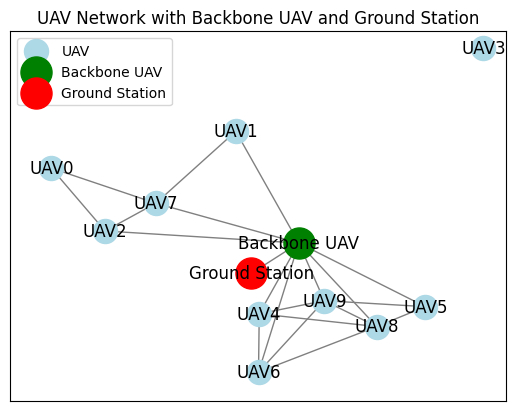

In [3]:
# Run the Simulation
simulation.run_simulation(uav_network, total_time, update_interval, move_range, connection_range, backbone_range, num_packets)

# Update network connections
uav_network = simulation.update_network_connections(uav_network, connection_range, backbone_range)

# Update Neo4j Database with the new positions and connections
simulation.update_neo4j_database(uav_network)

# Now draw the graph to visualize the updated network
simulation.draw_graph(uav_network)

# Close Neo4j Connection
simulation.close()